HW07: КЛАСТЕРИЗАЦИЯ ТРЕХ ДАТАСЕТОВ

НАЧИНАЕМ ОБРАБОТКУ ДАТАСЕТА 01

ДАТАСЕТ 01
Размер: 12000 строк, 9 столбцов
Типы признаков:
float64    8
int64      1
Name: count, dtype: int64
Препроцессинг: StandardScaler применен

--- KMeans кластеризация ---


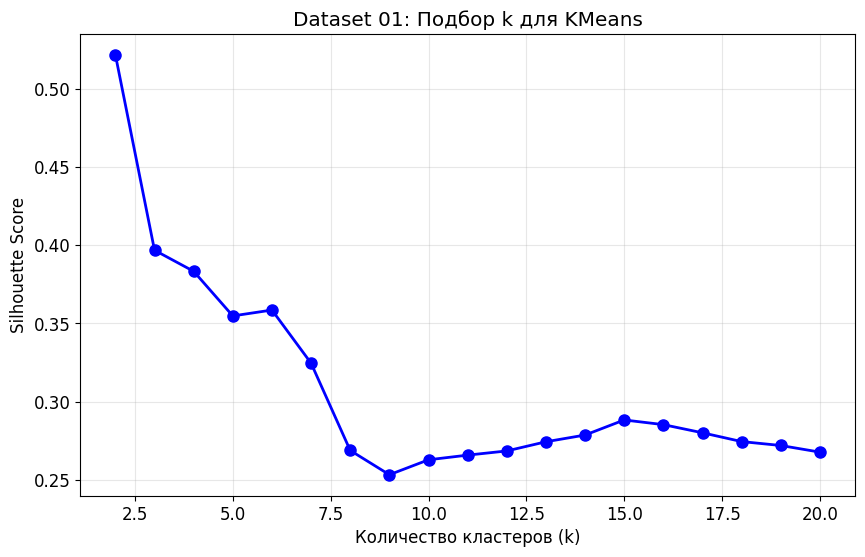

Оптимальное k: 2
Silhouette: 0.5216
Davies-Bouldin: 0.6853

--- DBSCAN кластеризация ---
Оптимальный eps: 1.70
Кластеров: 2, Шум: 0.00%
Silhouette: 0.5216

--- Визуализация результатов PCA ---


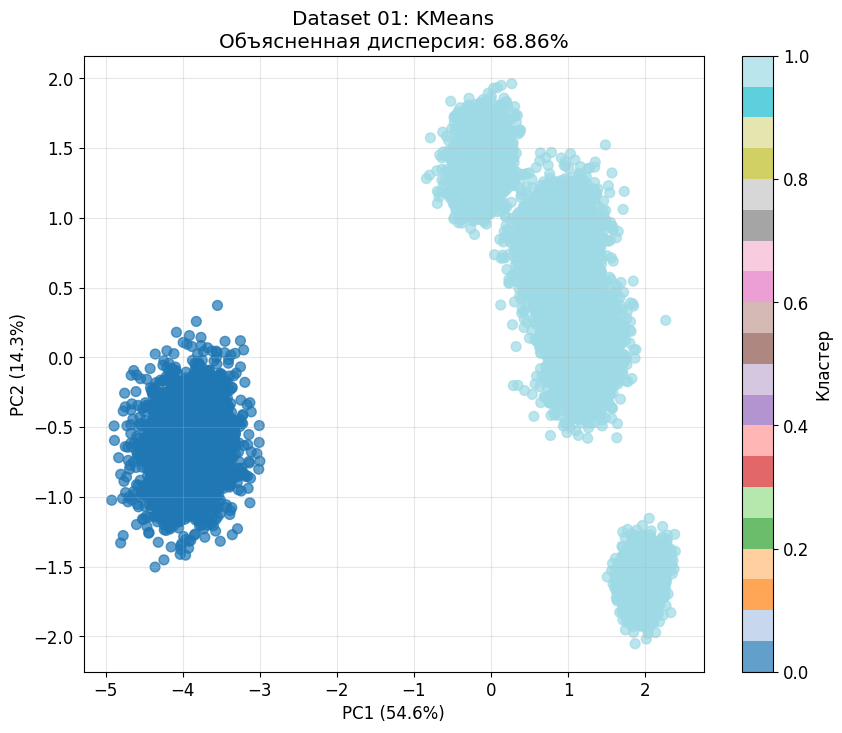

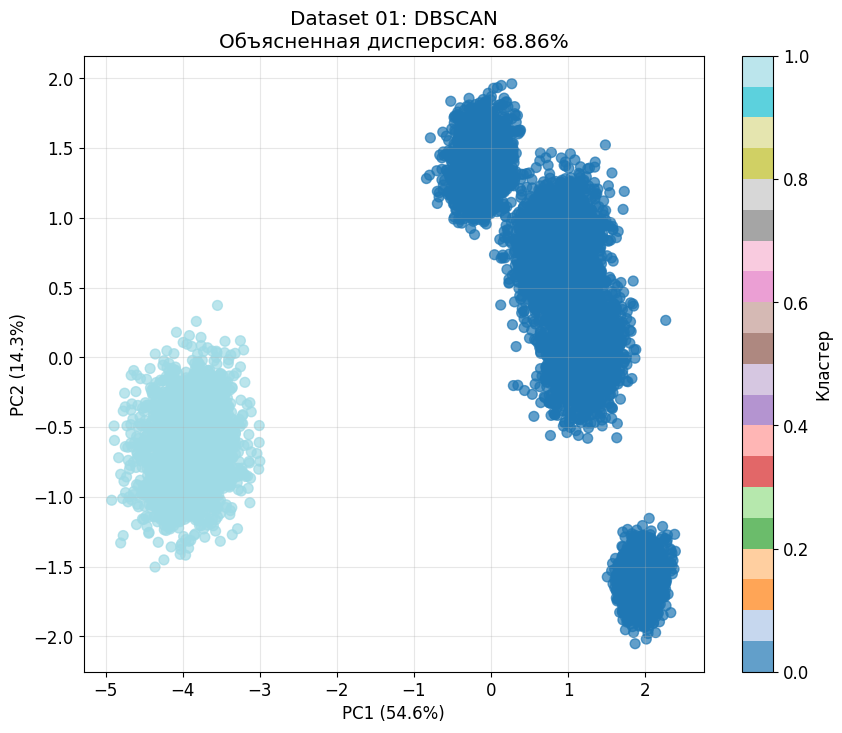

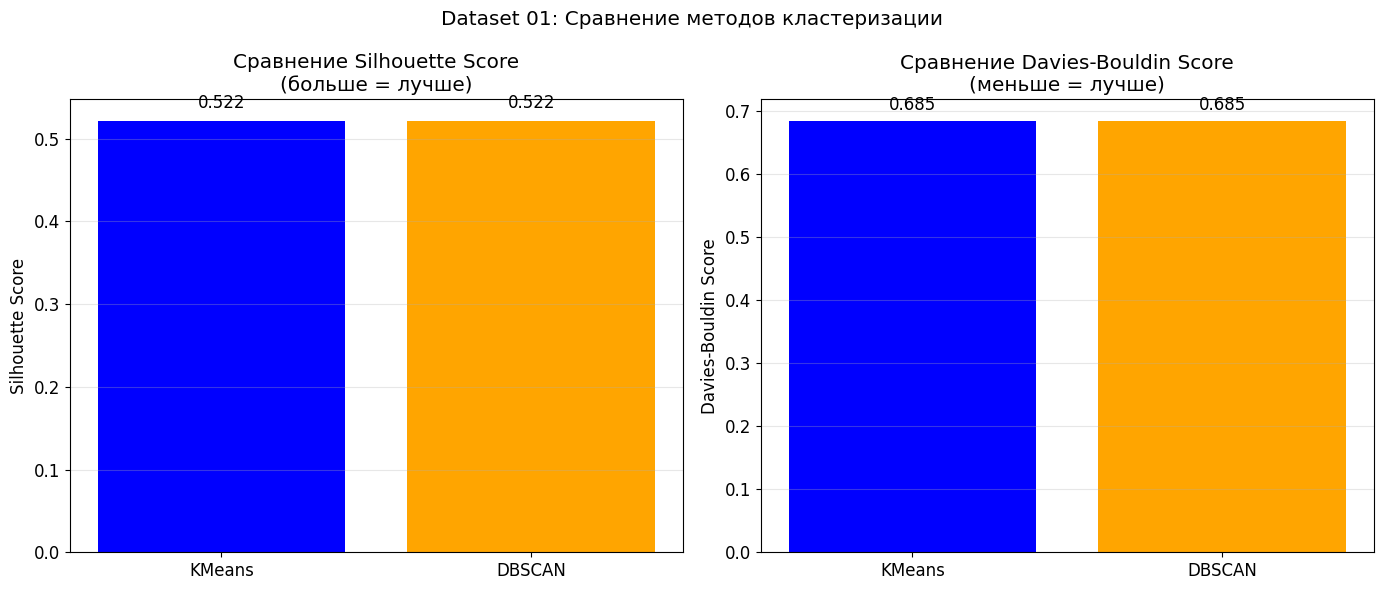


--- Выбор лучшего метода ---
Выбран DBSCAN (Silhouette: 0.5216 > 0.5216)

--- Проверка устойчивости KMeans ---


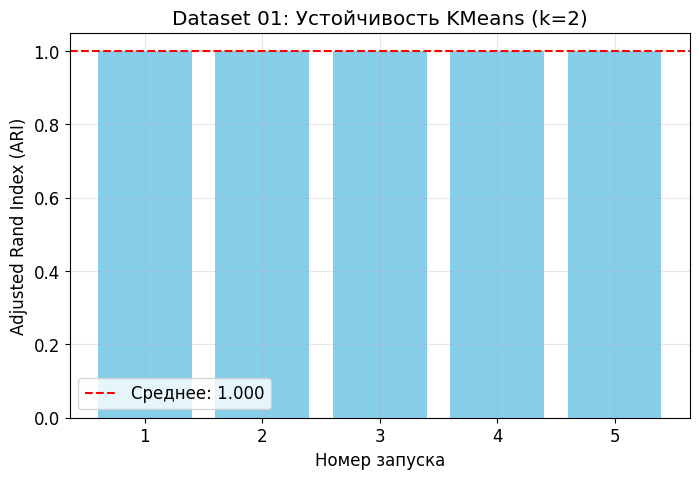

Средний ARI: 1.0000
Стандартное отклонение: 0.0000

✓ Датсет 01 обработан и сохранен

НАЧИНАЕМ ОБРАБОТКУ ДАТАСЕТА 02

ДАТАСЕТ 02
Размер: 8000 строк, 4 столбцов
Типы признаков:
float64    3
int64      1
Name: count, dtype: int64
Препроцессинг: StandardScaler применен

--- KMeans кластеризация ---


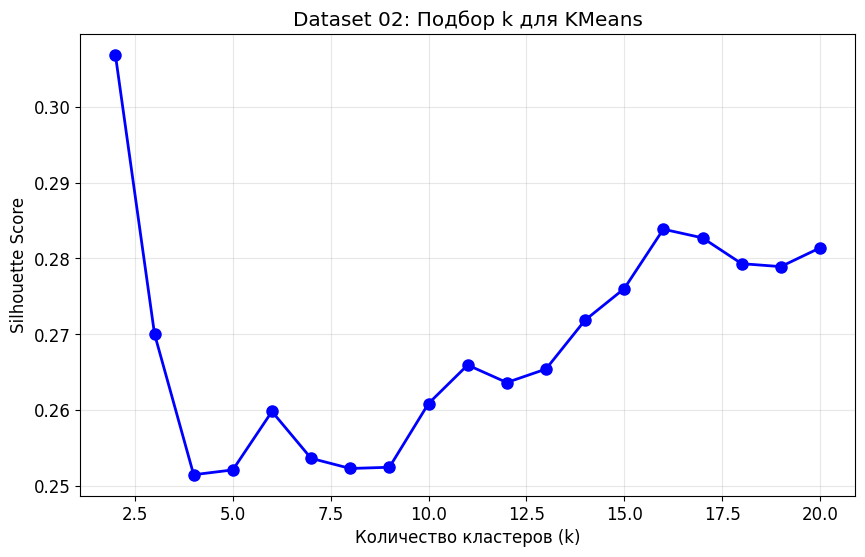

Оптимальное k: 2
Silhouette: 0.3069
Davies-Bouldin: 1.3235

--- DBSCAN кластеризация ---
Оптимальный eps: 0.30
Кластеров: 5, Шум: 7.24%
Silhouette: 0.0852

--- Визуализация результатов PCA ---


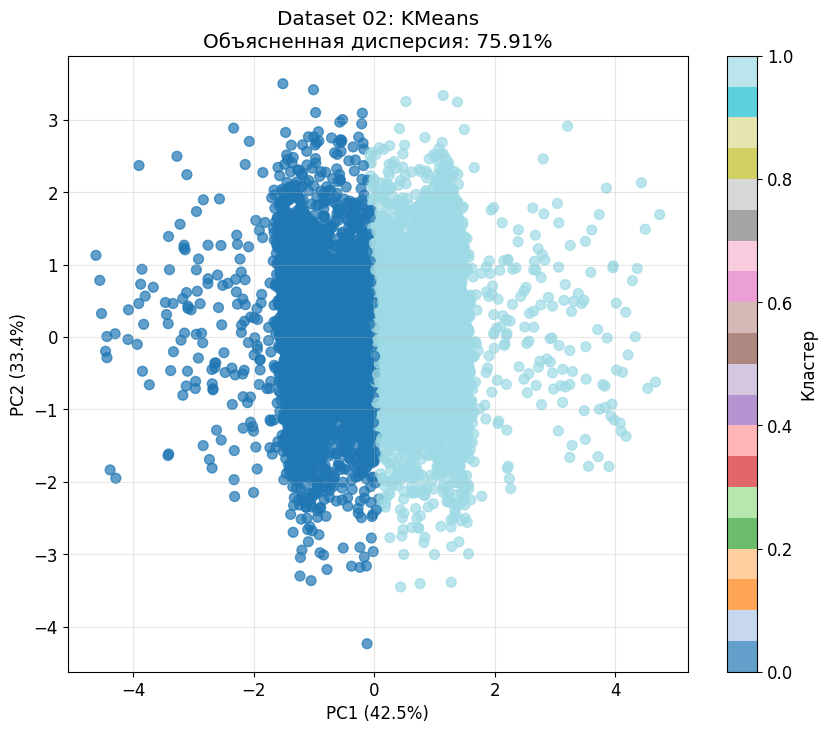

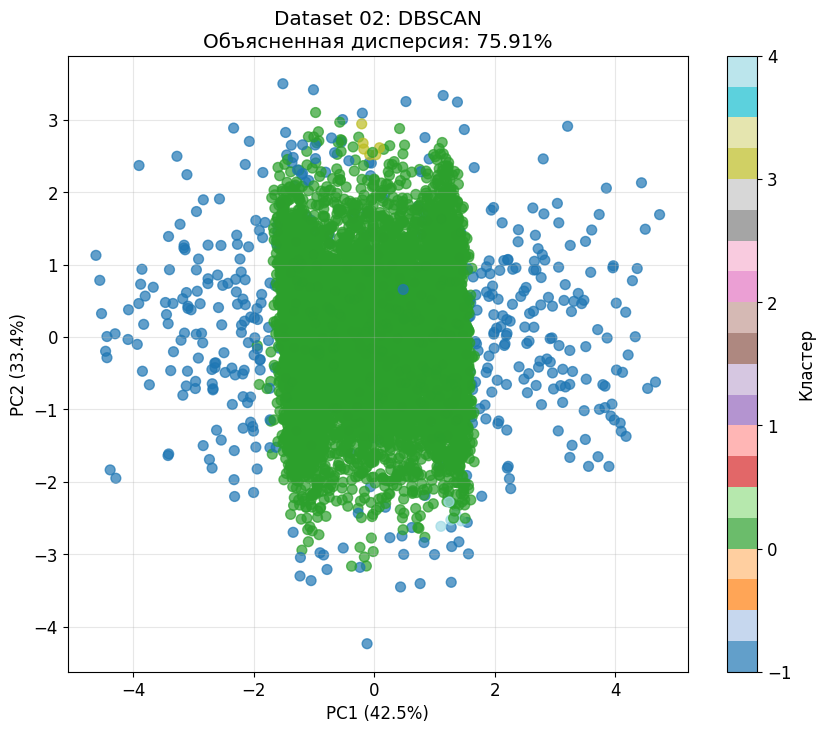

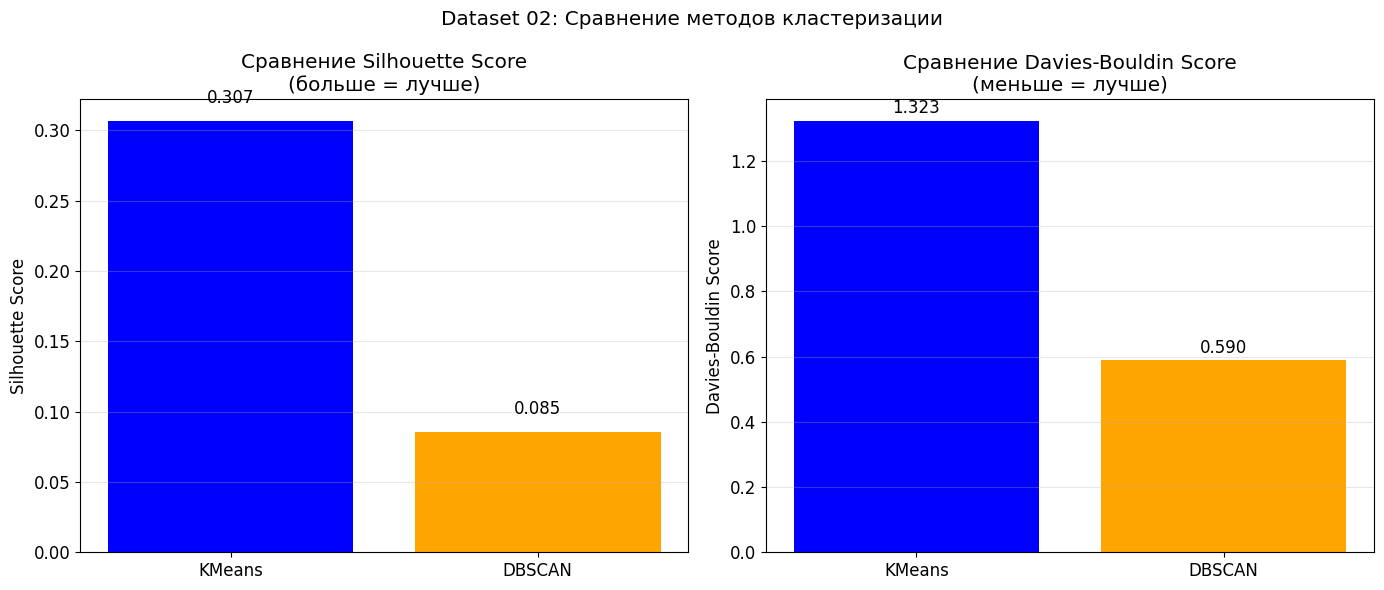


--- Выбор лучшего метода ---
Выбран KMeans (Silhouette: 0.3069 > 0.0852)

✓ Датсет 02 обработан и сохранен

НАЧИНАЕМ ОБРАБОТКУ ДАТАСЕТА 03

ДАТАСЕТ 03
Размер: 15000 строк, 5 столбцов
Типы признаков:
float64    4
int64      1
Name: count, dtype: int64
Препроцессинг: StandardScaler применен

--- KMeans кластеризация ---


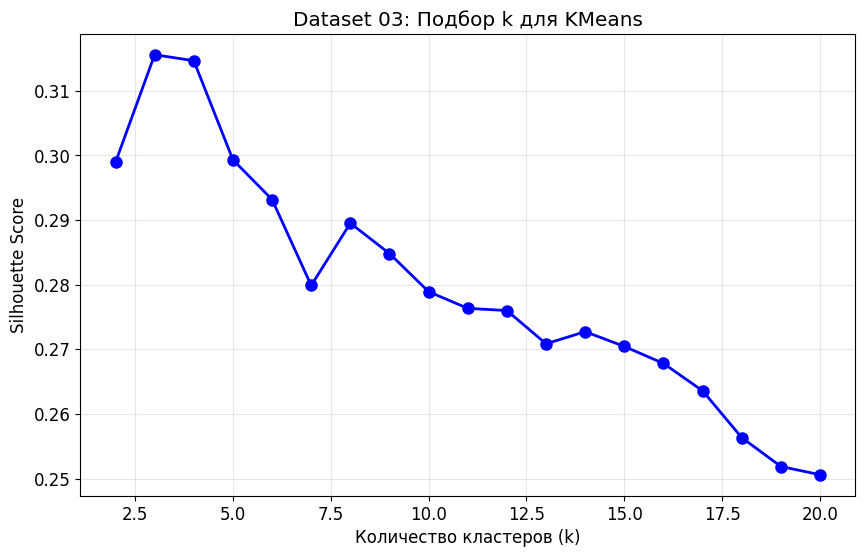

Оптимальное k: 3
Silhouette: 0.3155
Davies-Bouldin: 1.1577

--- Agglomerative кластеризация ---
Лучший метод: average с k=2
Silhouette: 0.4253

--- Визуализация результатов PCA ---


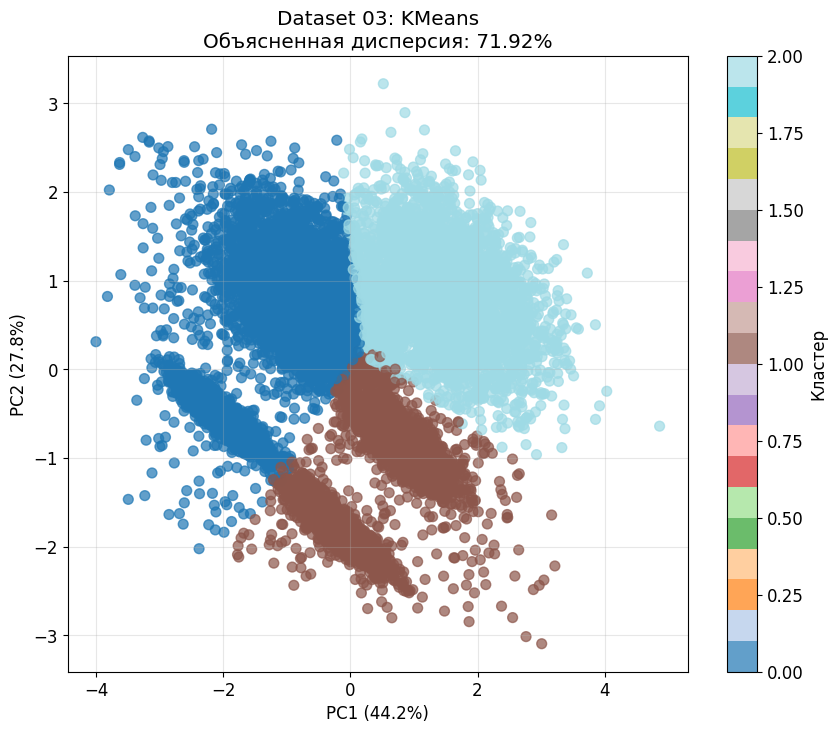

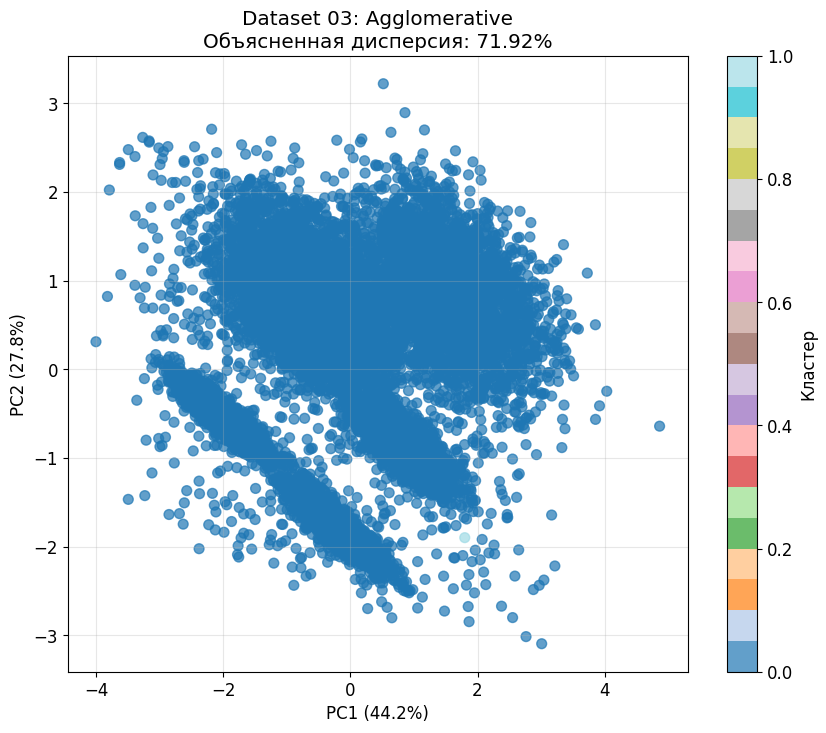

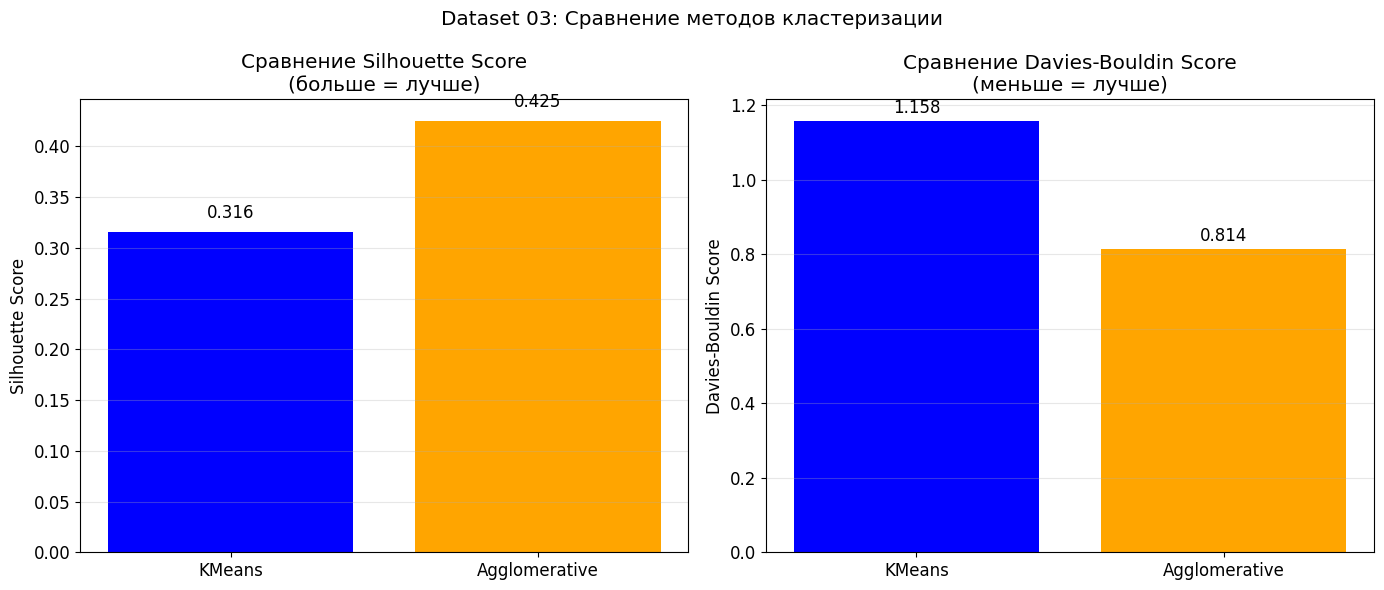


--- Выбор лучшего метода ---
Выбран Agglomerative (Silhouette: 0.4253 > 0.3155)

✓ Датсет 03 обработан и сохранен

СОХРАНЕНИЕ АРТЕФАКТОВ
Созданные файлы:
  - artifacts/metrics_summary.json
  - artifacts/best_configs.json
  - artifacts/labels/labels_hw07_ds1.csv
  - artifacts/labels/labels_hw07_ds2.csv
  - artifacts/labels/labels_hw07_ds3.csv

Создано графиков: 17

ИТОГОВОЕ СРАВНЕНИЕ МЕТРИК ПО ВСЕМ ДАТАСЕТАМ

Сводная таблица метрик (лучший метод для каждого датасета):
----------------------------------------------------------------------------------------------------
Датасет      Метод           Silhouette   Davies-Bouldin  Кластеры   Примечания                    
----------------------------------------------------------------------------------------------------
dataset01    DBSCAN          0.5216       0.6853          2          eps=1.70, шум=0.0%            
dataset02    KMeans          0.3069       1.3235          2          k=2                           
dataset03    Agglomerativ

In [6]:
# --- HW07: Кластеризация трех датасетов ---
# Обработка dataset01, dataset02, dataset03

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')
import json
import os
from scipy.cluster.hierarchy import dendrogram, linkage

# Создание папок для артефактов
os.makedirs('artifacts/figures', exist_ok=True)
os.makedirs('artifacts/labels', exist_ok=True)

plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

# ============================================================================
# ФУНКЦИИ ДЛЯ ОБРАБОТКИ ДАТАСЕТОВ
# ============================================================================

def load_and_preprocess_dataset(dataset_num):
    """Загрузка и препроцессинг датасета"""
    filename = f'data/S07-hw-dataset-{dataset_num:02d}.csv'
    df = pd.read_csv(filename)
    
    print(f"\n{'='*60}")
    print(f"ДАТАСЕТ {dataset_num:02d}")
    print(f"{'='*60}")
    
    # EDA
    print(f"Размер: {df.shape[0]} строк, {df.shape[1]} столбцов")
    print(f"Типы признаков:")
    print(df.dtypes.value_counts())
    
    # Проверка пропусков
    missing = df.isnull().sum().sum()
    if missing > 0:
        print(f"Пропуски: {missing} значений")
    
    # Подготовка данных
    sample_ids = df['sample_id']
    X = df.drop('sample_id', axis=1)
    
    # Препроцессинг (все датасеты содержат только числовые признаки)
    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    X_processed = preprocessor.fit_transform(X)
    print(f"Препроцессинг: StandardScaler применен")
    
    return X_processed, sample_ids, X.columns

def run_kmeans(X_processed, dataset_num):
    """Выполнение KMeans кластеризации"""
    print("\n--- KMeans кластеризация ---")
    
    # Подбор оптимального k
    k_range = range(2, 21)
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_processed)
        
        if len(np.unique(labels)) > 1:
            score = silhouette_score(X_processed, labels)
        else:
            score = 0
        silhouette_scores.append(score)
    
    # Определение оптимального k
    optimal_k = k_range[np.argmax(silhouette_scores)]
    
    # График подбора k
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Количество кластеров (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Dataset {dataset_num:02d}: Подбор k для KMeans')
    plt.grid(True, alpha=0.3)
    plt.savefig(f'artifacts/figures/dataset{dataset_num:02d}_kmeans_k_selection.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Обучение с оптимальным k
    kmeans_best = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels = kmeans_best.fit_predict(X_processed)
    
    # Вычисление метрик
    metrics = {
        'silhouette': silhouette_score(X_processed, labels),
        'davies_bouldin': davies_bouldin_score(X_processed, labels),
        'calinski_harabasz': calinski_harabasz_score(X_processed, labels),
        'n_clusters': optimal_k,
        'noise_ratio': 0.0
    }
    
    print(f"Оптимальное k: {optimal_k}")
    print(f"Silhouette: {metrics['silhouette']:.4f}")
    print(f"Davies-Bouldin: {metrics['davies_bouldin']:.4f}")
    
    return labels, metrics, optimal_k

def run_dbscan(X_processed, dataset_num):
    """Выполнение DBSCAN кластеризации"""
    print("\n--- DBSCAN кластеризация ---")
    
    # Подбор параметров
    min_samples = 5
    eps_values = np.arange(0.1, 3.0, 0.2)
    results = []
    
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_processed)
        
        noise_ratio = np.sum(labels == -1) / len(labels)
        non_noise_mask = labels != -1
        
        if np.sum(non_noise_mask) > 1 and len(np.unique(labels[non_noise_mask])) > 1:
            X_non_noise = X_processed[non_noise_mask]
            labels_non_noise = labels[non_noise_mask]
            silhouette = silhouette_score(X_non_noise, labels_non_noise)
            n_clusters = len(np.unique(labels_non_noise))
        else:
            silhouette = 0
            n_clusters = 0
        
        results.append({
            'eps': eps,
            'silhouette': silhouette,
            'n_clusters': n_clusters,
            'noise_ratio': noise_ratio
        })
    
    # Выбор оптимального eps
    results_df = pd.DataFrame(results)
    valid_results = results_df[results_df['n_clusters'] >= 2]
    
    if not valid_results.empty:
        optimal_row = valid_results.loc[valid_results['silhouette'].idxmax()]
        optimal_eps = optimal_row['eps']
    else:
        optimal_eps = 0.5
    
    # Обучение с оптимальными параметрами
    dbscan_best = DBSCAN(eps=optimal_eps, min_samples=min_samples)
    labels = dbscan_best.fit_predict(X_processed)
    
    # Статистика
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    noise_ratio = np.sum(labels == -1) / len(labels)
    
    # Метрики (без шума)
    non_noise_mask = labels != -1
    if np.sum(non_noise_mask) > 1 and len(np.unique(labels[non_noise_mask])) > 1:
        X_non_noise = X_processed[non_noise_mask]
        labels_non_noise = labels[non_noise_mask]
        
        metrics = {
            'silhouette': silhouette_score(X_non_noise, labels_non_noise),
            'davies_bouldin': davies_bouldin_score(X_non_noise, labels_non_noise),
            'calinski_harabasz': calinski_harabasz_score(X_non_noise, labels_non_noise),
            'n_clusters': n_clusters,
            'noise_ratio': noise_ratio,
            'eps': optimal_eps,
            'min_samples': min_samples
        }
    else:
        metrics = {
            'silhouette': np.nan,
            'davies_bouldin': np.nan,
            'calinski_harabasz': np.nan,
            'n_clusters': n_clusters,
            'noise_ratio': noise_ratio,
            'eps': optimal_eps,
            'min_samples': min_samples
        }
    
    print(f"Оптимальный eps: {optimal_eps:.2f}")
    print(f"Кластеров: {n_clusters}, Шум: {noise_ratio:.2%}")
    if not np.isnan(metrics['silhouette']):
        print(f"Silhouette: {metrics['silhouette']:.4f}")
    
    return labels, metrics

def run_agglomerative(X_processed, dataset_num):
    """Выполнение Agglomerative кластеризации"""
    print("\n--- Agglomerative кластеризация ---")
    
    # Тестируем разные linkage методы
    linkage_methods = ['ward', 'complete', 'average']
    results = []
    
    for linkage_method in linkage_methods:
        # Подбор k для каждого метода
        k_range = range(2, 11)
        silhouette_scores = []
        
        for k in k_range:
            agg = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)
            labels = agg.fit_predict(X_processed)
            
            if len(np.unique(labels)) > 1:
                score = silhouette_score(X_processed, labels)
            else:
                score = 0
            silhouette_scores.append(score)
        
        if silhouette_scores:
            best_k = k_range[np.argmax(silhouette_scores)]
            best_score = max(silhouette_scores)
            results.append({
                'linkage': linkage_method,
                'best_k': best_k,
                'best_score': best_score
            })
    
    # Выбор лучшего linkage метода
    results_df = pd.DataFrame(results)
    best_method = results_df.loc[results_df['best_score'].idxmax()]
    
    # Обучение с лучшими параметрами
    agg_best = AgglomerativeClustering(
        n_clusters=int(best_method['best_k']), 
        linkage=best_method['linkage']
    )
    labels = agg_best.fit_predict(X_processed)
    
    # Метрики
    metrics = {
        'silhouette': silhouette_score(X_processed, labels),
        'davies_bouldin': davies_bouldin_score(X_processed, labels),
        'calinski_harabasz': calinski_harabasz_score(X_processed, labels),
        'n_clusters': int(best_method['best_k']),
        'linkage': best_method['linkage'],
        'noise_ratio': 0.0
    }
    
    print(f"Лучший метод: {best_method['linkage']} с k={best_method['best_k']}")
    print(f"Silhouette: {metrics['silhouette']:.4f}")
    
    return labels, metrics

def visualize_pca(X_processed, labels, dataset_num, method_name):
    """Визуализация результатов с помощью PCA"""
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_processed)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=labels, cmap='tab20', alpha=0.7, s=50)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.title(f'Dataset {dataset_num:02d}: {method_name}\n'
              f'Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.2%}')
    plt.colorbar(scatter, label='Кластер')
    plt.grid(True, alpha=0.3)
    
    filename = f'artifacts/figures/dataset{dataset_num:02d}_pca_{method_name.lower()}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    
    return X_pca

def compare_methods(metrics_kmeans, metrics_other, dataset_num, other_method_name):
    """Сравнение методов кластеризации"""
    methods = ['KMeans', other_method_name]
    silhouette_vals = [metrics_kmeans['silhouette'], metrics_other['silhouette']]
    db_vals = [metrics_kmeans['davies_bouldin'], metrics_other['davies_bouldin']]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Silhouette сравнение
    bars1 = ax1.bar(methods, silhouette_vals, color=['blue', 'orange'])
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Сравнение Silhouette Score\n(больше = лучше)')
    ax1.grid(True, alpha=0.3, axis='y')
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')
    
    # Davies-Bouldin сравнение
    bars2 = ax2.bar(methods, db_vals, color=['blue', 'orange'])
    ax2.set_ylabel('Davies-Bouldin Score')
    ax2.set_title('Сравнение Davies-Bouldin Score\n(меньше = лучше)')
    ax2.grid(True, alpha=0.3, axis='y')
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')
    
    plt.suptitle(f'Dataset {dataset_num:02d}: Сравнение методов кластеризации')
    plt.tight_layout()
    plt.savefig(f'artifacts/figures/dataset{dataset_num:02d}_methods_comparison.png', 
                dpi=150, bbox_inches='tight')
    plt.show()

def check_kmeans_stability(X_processed, optimal_k, dataset_num):
    """Проверка устойчивости KMeans"""
    print("\n--- Проверка устойчивости KMeans ---")
    
    n_runs = 5
    stability_results = []
    
    # Эталонный запуск
    kmeans_ref = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels_ref = kmeans_ref.fit_predict(X_processed)
    
    for run in range(n_runs):
        kmeans_run = KMeans(n_clusters=optimal_k, random_state=run*100, n_init=10)
        labels_run = kmeans_run.fit_predict(X_processed)
        ari_score = adjusted_rand_score(labels_ref, labels_run)
        stability_results.append(ari_score)
    
    # График устойчивости
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, n_runs+1), stability_results, color='skyblue')
    plt.axhline(y=np.mean(stability_results), color='red', linestyle='--', 
               label=f'Среднее: {np.mean(stability_results):.3f}')
    plt.xlabel('Номер запуска')
    plt.ylabel('Adjusted Rand Index (ARI)')
    plt.title(f'Dataset {dataset_num:02d}: Устойчивость KMeans (k={optimal_k})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'artifacts/figures/dataset{dataset_num:02d}_kmeans_stability.png', 
                dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Средний ARI: {np.mean(stability_results):.4f}")
    print(f"Стандартное отклонение: {np.std(stability_results):.4f}")
    
    return np.mean(stability_results)

# ============================================================================
# ОСНОВНОЙ КОД ДЛЯ 3 ДАТАСЕТОВ
# ============================================================================

print("="*80)
print("HW07: КЛАСТЕРИЗАЦИЯ ТРЕХ ДАТАСЕТОВ")
print("="*80)

# Словари для хранения результатов
all_metrics = {}
all_best_configs = {}
all_best_labels = {}

# Обработка каждого датасета
for dataset_num in [1, 2, 3]:
    print(f"\n{'='*80}")
    print(f"НАЧИНАЕМ ОБРАБОТКУ ДАТАСЕТА {dataset_num:02d}")
    print(f"{'='*80}")
    
    # 1. Загрузка и препроцессинг
    X_processed, sample_ids, feature_names = load_and_preprocess_dataset(dataset_num)
    
    # 2. KMeans кластеризация
    kmeans_labels, kmeans_metrics, optimal_k = run_kmeans(X_processed, dataset_num)
    
    # 3. Второй метод кластеризации (для разных датасетов разные методы)
    if dataset_num == 1:
        # Для dataset01 используем DBSCAN
        other_labels, other_metrics = run_dbscan(X_processed, dataset_num)
        other_method_name = "DBSCAN"
    elif dataset_num == 2:
        # Для dataset02 используем DBSCAN (лучше для нелинейных структур)
        other_labels, other_metrics = run_dbscan(X_processed, dataset_num)
        other_method_name = "DBSCAN"
    else:  # dataset_num == 3
        # Для dataset03 используем Agglomerative
        other_labels, other_metrics = run_agglomerative(X_processed, dataset_num)
        other_method_name = "Agglomerative"
    
    # 4. Визуализация PCA для обоих методов
    print("\n--- Визуализация результатов PCA ---")
    
    # Визуализация KMeans
    pca_kmeans = visualize_pca(X_processed, kmeans_labels, dataset_num, "KMeans")
    
    # Визуализация второго метода
    pca_other = visualize_pca(X_processed, other_labels, dataset_num, other_method_name)
    
    # 5. Сравнение методов
    compare_methods(kmeans_metrics, other_metrics, dataset_num, other_method_name)
    
    # 6. Выбор лучшего метода для этого датасета
    print("\n--- Выбор лучшего метода ---")
    
    # Сравниваем по silhouette score
    kmeans_silhouette = kmeans_metrics['silhouette']
    other_silhouette = other_metrics['silhouette'] if not np.isnan(other_metrics['silhouette']) else 0
    
    if kmeans_silhouette > other_silhouette:
        best_method = "KMeans"
        best_labels = kmeans_labels
        best_metrics = kmeans_metrics
        print(f"Выбран KMeans (Silhouette: {kmeans_silhouette:.4f} > {other_silhouette:.4f})")
    else:
        best_method = other_method_name
        best_labels = other_labels
        best_metrics = other_metrics
        print(f"Выбран {other_method_name} (Silhouette: {other_silhouette:.4f} > {kmeans_silhouette:.4f})")
    
    # 7. Проверка устойчивости только для dataset01
    if dataset_num == 1:
        stability_score = check_kmeans_stability(X_processed, optimal_k, dataset_num)
    
    # 8. Сохранение результатов для этого датасета
    dataset_key = f'dataset{dataset_num:02d}'
    
    # Метрики
    all_metrics[dataset_key] = {
        'KMeans': kmeans_metrics,
        other_method_name: other_metrics
    }
    
    # Лучшая конфигурация
    if best_method == "KMeans":
        all_best_configs[dataset_key] = {
            'method': 'KMeans',
            'n_clusters': kmeans_metrics['n_clusters'],
            'random_state': 42,
            'n_init': 10
        }
    elif best_method == "DBSCAN":
        all_best_configs[dataset_key] = {
            'method': 'DBSCAN',
            'eps': other_metrics['eps'],
            'min_samples': other_metrics['min_samples'],
            'n_clusters': other_metrics['n_clusters'],
            'noise_ratio': other_metrics['noise_ratio']
        }
    else:  # Agglomerative
        all_best_configs[dataset_key] = {
            'method': 'Agglomerative',
            'n_clusters': other_metrics['n_clusters'],
            'linkage': other_metrics['linkage']
        }
    
    # Метки кластеров
    labels_df = pd.DataFrame({
        'sample_id': sample_ids,
        'cluster_label': best_labels
    })
    labels_df.to_csv(f'artifacts/labels/labels_hw07_ds{dataset_num}.csv', index=False)
    
    print(f"\n✓ Датсет {dataset_num:02d} обработан и сохранен")

# ============================================================================
# СОХРАНЕНИЕ АРТЕФАКТОВ И ИТОГИ
# ============================================================================

print(f"\n{'='*80}")
print("СОХРАНЕНИЕ АРТЕФАКТОВ")
print(f"{'='*80}")

# Сохранение сводки метрик
with open('artifacts/metrics_summary.json', 'w') as f:
    json.dump(all_metrics, f, indent=4, default=str)

# Сохранение лучших конфигураций
with open('artifacts/best_configs.json', 'w') as f:
    json.dump(all_best_configs, f, indent=4, default=str)

print("Созданные файлы:")
print("  - artifacts/metrics_summary.json")
print("  - artifacts/best_configs.json")
for i in [1, 2, 3]:
    print(f"  - artifacts/labels/labels_hw07_ds{i}.csv")

# Подсчет графиков
import glob
figures = glob.glob('artifacts/figures/*.png')
print(f"\nСоздано графиков: {len(figures)}")

print(f"\n{'='*80}")
print("ИТОГОВОЕ СРАВНЕНИЕ МЕТРИК ПО ВСЕМ ДАТАСЕТАМ")
print(f"{'='*80}")

print("\nСводная таблица метрик (лучший метод для каждого датасета):")
print("-"*100)
print(f"{'Датасет':<12} {'Метод':<15} {'Silhouette':<12} {'Davies-Bouldin':<15} {'Кластеры':<10} {'Примечания':<30}")
print("-"*100)

for dataset_num in [1, 2, 3]:
    dataset_key = f'dataset{dataset_num:02d}'
    config = all_best_configs[dataset_key]
    method = config['method']
    
    if method == "KMeans":
        metrics = all_metrics[dataset_key]['KMeans']
        notes = f"k={metrics['n_clusters']}"
    elif method == "DBSCAN":
        metrics = all_metrics[dataset_key]['DBSCAN']
        notes = f"eps={metrics['eps']:.2f}, шум={metrics['noise_ratio']:.1%}"
    else:  # Agglomerative
        metrics = all_metrics[dataset_key]['Agglomerative']
        notes = f"linkage={metrics['linkage']}"
    
    silhouette = metrics['silhouette']
    db = metrics['davies_bouldin']
    n_clusters = metrics['n_clusters']
    
    print(f"{dataset_key:<12} {method:<15} {silhouette:<12.4f} {db:<15.4f} {n_clusters:<10} {notes:<30}")

print("-"*100)

print(f"\n{'='*80}")
print("ВЫПОЛНЕНИЕ ЗАВЕРШЕНО УСПЕШНО!")
print("Все 3 датасета обработаны, артефакты сохранены.")
print(f"{'='*80}")